In [1]:
%%sh
pip install --upgrade pip -q
pip install whylogs -U -q
pip install feast -U -q
pip install Pygments -q


# Context

In this walkthrough, we'll see how you can use Feast and whylogs together at different parts of your ML pipeline - We'll use Feast to set up an online feature store, and then use it to enrich our serving data with additional features. After assembling our feature vector, we'll proceed to log it with whylogs. As the requests for prediction arrives, the logged input features will be statistically profiled. We will explore these profiles to see what kind of insights we can have.



To do so, we'll use a sample dataset of daily taxi rides in NYC, extracted from [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Our final goal could be a prediction requested at the start of a given ride. This prediction could be whether the customer will give a high tip to the driver, or maybe whether the customer will give him a good review.  As an input to the prediction model, in addition to the ride information (like number of passengers, day of the week or trip distance), we might be interested in enriching our feature vector with information about the driver, like the driver's average speed, average rating or avg trips in the last 24 hours, with the hopes of improving the model's performances.

![alt text](images/context.jpg "Title")

The info about the specific ride will be known at inference time. However, the driver statistics might be available to us in a different data source, updated at specific time intervals. We will join these information to assemble a single feature vector by using Feast to set up an online feature store. Feast will materialize the features into the online store from a data source file. This data source will have driver statistic's, according the each driver's ID updated in an hourly basis.

We will simulate a production pipeline, where requests for predictions will be made at different timestamps. We'll then log the feature vectors for each request into daily profiles for a period of 7 days. We'll then see how to inspect the summary for a given profile, and how to inspect multiple profiles across time.

# Changes in Data

Let's consider some scenarios in which logging and visualizing features would be helpful.

## Data Freshness

In this example, we have updated information about drivers in an hourly basis. Let's simulate a scenario in which this frequency gets affected by some reason, and for a particular period we have new information accessible only in 2-hour cycles.

## Changes in Customer Behavior

Let's consider a scenario where people's behavior changes: maybe people are riding less and in groups of fewer people.  For example, when covid started, the number of rides certainly plummeted, and we could expect to see a dip in the number of passengers for each ride (for social distancing measures).

We could also have a change in the criterias people use to rate a driver. For example, now the given rates, or reviews, for each driver could be affected by specific services provided, like the presence of alcohol and/or physical barriers to ensure social distancing. 


# The Feature Repository

## Registering feature definitions and deploying your feature store

For this walkthrough, the feature repository is already created for you in the `feature_repo` folder. It was first created using [Feast's quickstart example](https://docs.feast.dev/getting-started/quickstart) as a guide, and then making the required changes to adapt to our use case.  Let's navigate to it:

In [3]:
%cd feast_whylogs_example/feature_repo
# Depending on where you're running this notebook from, you might need to change the above line with:
# %cd feature_repo


/mnt/c/Users/felip/OneDrive/Documentos/Projects/whylogs-felipeadachi/examples/feast_whylogs_example/feature_repo


Make sure you're on the right folder. You should see an empty data folder (we'll populate it with our data source later), the `example.py` python script, which contains our feature definitions, and the `feature_store.yaml` configuration file.

In [4]:
!ls -R

.:
__init__.py  data  example.py  feature_store.yaml

./data:


Now, let's download our data source and store it locally in our feature repository:

In [3]:
import pandas as pd
path = f"https://whylabs-public.s3.us-west-2.amazonaws.com/whylogs_examples/feast_integration/driver_stats.parquet"
print(f"Loading data from {path}")
driver_stats = pd.read_parquet(path)
print(f"Saving file source locally")

driver_stats.to_parquet("data/driver_stats.parquet")

Loading data from https://whylabs-public.s3.us-west-2.amazonaws.com/whylogs_examples/feast_integration/driver_stats.parquet
Saving file source locally


In the data source, we have driver's statistics on an hourly basis, such as the average trips done on the last 24 hours, average rating on the last month and average driving speed. You can see more information on how this data was created at the end of this notebook, in the Appendix.

In [4]:
driver_stats.dtypes

index                     float64
event_timestamp    datetime64[ns]
driver_id                   int64
created            datetime64[ns]
avg_daily_trips             int64
rate_1m                     int64
avg_speed                 float64
dtype: object

Now, we will scan the python files in our feature repository for feature views/entity definitions, register the objects and deploy the infrastructure with the `feast apply command`.

In [5]:
!feast apply

Created entity driver_id
Created feature view driver_hourly_stats


Let's also load our rides dataframe. In it we, have features about rides made during 10-Feb to 16-Feb (2020), such as the number of passengers, trip distante and pickup date and time. 

In [6]:
import pandas as pd

path = f"https://whylabs-public.s3.us-west-2.amazonaws.com/whylogs_examples/nyc_taxi_rides_feb_2020_changed.parquet"
print(f"Loading data from {path}")
rides_df = pd.read_parquet(path)

rides_df.dtypes

Loading data from https://whylabs-public.s3.us-west-2.amazonaws.com/whylogs_examples/nyc_taxi_rides_feb_2020_changed.parquet


pickup_weekday                   int64
passenger_count                float64
trip_distance                  float64
PULocationID                     int64
tpep_pickup_datetime    datetime64[ns]
pickup_date                     object
dtype: object

# Additional Transformations

The real dataset doesn't contain information regarding the taxi driver that conducted the ride. Since our goal is to enrich the dataset with driver features from an external data source, we will create a `driver_id` column. For simplicity, let's consider that this dataset contains ride information of only 2 drivers (IDs `1001` and `1002`)

In [7]:
import numpy as np
rides_df['driver_id'] = np.random.randint(1001, 1003, rides_df.shape[0])

# Features: Load, Fetch and Log

We will iterate on `rides_df`, where each row represents a point in time in which we will request a prediction. For each request, we will:

- Materialize latest features into our online feature store
- Get features from the online feature store
- Join the features from the online store (driver features) with ride features
- Log features with whylogs into a profile

We'll consider that the __materialization__ job is run hourly. To simulate that, we will call __materialize__ for the last rounded hour, based on the request's timestamp `tpep_pickup_datetime`.

In [8]:
from datetime import datetime, timedelta
from pprint import pprint
from feast import FeatureStore
from whylogs import get_or_create_session
import os
session = get_or_create_session()

# store = FeatureStore(repo_path="feast_whylogs_example/feature_repo")
store = FeatureStore(repo_path=".")
j=0

prev_time = datetime(2020, 2, 10, 00, 00)
target_time = datetime(2020, 2, 10, 1, 00)
store.materialize(start_date=prev_time,end_date=target_time)

day_to_log = datetime(2020, 2, 10)

with session.logger(dataset_name="my_dataset",dataset_timestamp=day_to_log) as logger:
    for index,row in rides_df.iterrows():

        request_timestamp = row['tpep_pickup_datetime']
        print("request timestamp: {}".format(request_timestamp))

        if request_timestamp.day > day_to_log.day:
            break

        if request_timestamp>target_time + timedelta(hours=1):
            target_time = datetime(request_timestamp.year,request_timestamp.month,request_timestamp.day,request_timestamp.hour)
            prev_time = target_time - timedelta(hours=1)
            store.materialize(start_date=prev_time,end_date=target_time)


        driver_feature_vector = store.get_online_features(
        features=[
            "driver_hourly_stats:rate_1m",
            "driver_hourly_stats:avg_daily_trips",
            "driver_hourly_stats:avg_speed"

        ],
        entity_rows=[{"driver_id": row['driver_id']},],
        ).to_dict()

        # Get features from both ride and driver
        assembled_feature_vector = {
            "pickup_weekday": row["pickup_weekday"],
            "passenger_count": row["passenger_count"],
            "trip_distance": row["trip_distance"],
            "PULocationID": row["PULocationID"],
            "driver_avg_daily_trips": driver_feature_vector["avg_daily_trips"][0],
            "driver_rate_1m": driver_feature_vector["rate_1m"][0],
            "driver_avg_speed": driver_feature_vector["avg_speed"][0],

        }

        # Now that we have the complete set of features, model prediction could go here.

        logger.log(assembled_feature_vector)
        print("######################################################")
    
    pprint(assembled_feature_vector)    
    profile = logger.profile

/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/marshmallow/fields.py:173: RemovedInMarshmallow4Warning: The 'default' argument to fields is deprecated. Use 'dump_default' instead.
  warnings.warn(
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/marshmallow/fields.py:181: RemovedInMarshmallow4Warning: The 'missing' argument to fields is deprecated. Use 'load_default' instead.
  warnings.warn(
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/whylogs/core/types/typeddataconverter.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  FLOAT_TYPES = (float, np.float)
02/24/2022 01:36:17 PM INFO:No config fi

WARN: Missing config
Materializing 1 feature views from 2020-02-10 00:00:00-03:00 to 2020-02-10 01:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 64.53it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


request timestamp: 2020-02-10 00:23:21
######################################################
request timestamp: 2020-02-10 01:19:01
######################################################
request timestamp: 2020-02-10 01:29:23
######################################################
request timestamp: 2020-02-10 02:44:20
Materializing 1 feature views from 2020-02-10 01:00:00-03:00 to 2020-02-10 02:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 98.72it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


######################################################
request timestamp: 2020-02-10 04:12:22
Materializing 1 feature views from 2020-02-10 03:00:00-03:00 to 2020-02-10 04:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 82.20it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


######################################################
request timestamp: 2020-02-10 05:09:40
Materializing 1 feature views from 2020-02-10 04:00:00-03:00 to 2020-02-10 05:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 95.82it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


######################################################
request timestamp: 2020-02-10 06:25:30
Materializing 1 feature views from 2020-02-10 05:00:00-03:00 to 2020-02-10 06:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 90.34it/s]


######################################################
request timestamp: 2020-02-10 06:33:09
######################################################
request timestamp: 2020-02-10 07:04:14


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-10 06:00:00-03:00 to 2020-02-10 07:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 85.76it/s]


######################################################
request timestamp: 2020-02-10 07:08:17
######################################################
request timestamp: 2020-02-10 07:10:55
######################################################
request timestamp: 2020-02-10 07:28:50
######################################################
request timestamp: 2020-02-10 07:31:06
######################################################
request timestamp: 2020-02-10 07:33:24
######################################################
request timestamp: 2020-02-10 08:04:45
Materializing 1 feature views from 2020-02-10 07:00:00-03:00 to 2020-02-10 08:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 83.54it/s]


######################################################
request timestamp: 2020-02-10 08:06:05
######################################################
request timestamp: 2020-02-10 08:29:17
######################################################
request timestamp: 2020-02-10 08:32:48
######################################################
request timestamp: 2020-02-10 08:34:16
######################################################
request timestamp: 2020-02-10 08:39:47
######################################################
request timestamp: 2020-02-10 08:47:59


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


######################################################
request timestamp: 2020-02-10 08:55:23
######################################################
request timestamp: 2020-02-10 09:00:31
Materializing 1 feature views from 2020-02-10 08:00:00-03:00 to 2020-02-10 09:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 88.18it/s]


######################################################
request timestamp: 2020-02-10 09:04:21
######################################################
request timestamp: 2020-02-10 09:04:36
######################################################
request timestamp: 2020-02-10 09:07:42
######################################################
request timestamp: 2020-02-10 09:10:56
######################################################
request timestamp: 2020-02-10 09:18:23
######################################################
request timestamp: 2020-02-10 09:26:47
######################################################
request timestamp: 2020-02-10 09:42:47
######################################################
request timestamp: 2020-02-10 10:05:28
Materializing 1 feature views from 2020-02-10 09:00:00-03:00 to 2020-02-10 10:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 68.05it/s]


######################################################
request timestamp: 2020-02-10 10:07:00
######################################################
request timestamp: 2020-02-10 10:25:54
######################################################
request timestamp: 2020-02-10 10:27:14
######################################################
request timestamp: 2020-02-10 10:31:00
######################################################
request timestamp: 2020-02-10 11:26:02
Materializing 1 feature views from 2020-02-10 10:00:00-03:00 to 2020-02-10 11:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 92.65it/s]


######################################################
request timestamp: 2020-02-10 11:27:20
######################################################
request timestamp: 2020-02-10 11:28:09
######################################################
request timestamp: 2020-02-10 11:36:24
######################################################
request timestamp: 2020-02-10 12:23:29
Materializing 1 feature views from 2020-02-10 11:00:00-03:00 to 2020-02-10 12:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 78.51it/s]


######################################################
request timestamp: 2020-02-10 12:28:16
######################################################
request timestamp: 2020-02-10 13:04:01
Materializing 1 feature views from 2020-02-10 12:00:00-03:00 to 2020-02-10 13:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 77.44it/s]


######################################################
request timestamp: 2020-02-10 13:16:55
######################################################
request timestamp: 2020-02-10 13:22:15
######################################################
request timestamp: 2020-02-10 13:31:53
######################################################
request timestamp: 2020-02-10 13:32:54
######################################################
request timestamp: 2020-02-10 13:48:58
######################################################
request timestamp: 2020-02-10 14:00:59
Materializing 1 feature views from 2020-02-10 13:00:00-03:00 to 2020-02-10 14:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 95.05it/s]


######################################################
request timestamp: 2020-02-10 14:14:46
######################################################
request timestamp: 2020-02-10 14:59:21
######################################################
request timestamp: 2020-02-10 15:19:13
Materializing 1 feature views from 2020-02-10 14:00:00-03:00 to 2020-02-10 15:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 81.11it/s]


######################################################
request timestamp: 2020-02-10 15:41:00
######################################################
request timestamp: 2020-02-10 15:45:49
######################################################
request timestamp: 2020-02-10 16:15:14
Materializing 1 feature views from 2020-02-10 15:00:00-03:00 to 2020-02-10 16:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 90.13it/s]


######################################################
request timestamp: 2020-02-10 16:20:37
######################################################
request timestamp: 2020-02-10 16:28:17
######################################################
request timestamp: 2020-02-10 16:40:33
######################################################
request timestamp: 2020-02-10 16:44:13
######################################################
request timestamp: 2020-02-10 16:45:15
######################################################
request timestamp: 2020-02-10 16:45:46
######################################################
request timestamp: 2020-02-10 17:04:12
Materializing 1 feature views from 2020-02-10 16:00:00-03:00 to 2020-02-10 17:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 87.90it/s]


######################################################
request timestamp: 2020-02-10 17:18:01
######################################################
request timestamp: 2020-02-10 17:41:14
######################################################
request timestamp: 2020-02-10 17:43:09
######################################################
request timestamp: 2020-02-10 17:47:37
######################################################
request timestamp: 2020-02-10 18:01:47
Materializing 1 feature views from 2020-02-10 17:00:00-03:00 to 2020-02-10 18:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 87.94it/s]


######################################################
request timestamp: 2020-02-10 18:05:25
######################################################
request timestamp: 2020-02-10 18:15:10
######################################################
request timestamp: 2020-02-10 18:20:39
######################################################
request timestamp: 2020-02-10 18:38:11
######################################################
request timestamp: 2020-02-10 18:38:17
######################################################
request timestamp: 2020-02-10 18:41:53
######################################################
request timestamp: 2020-02-10 18:46:52
######################################################
request timestamp: 2020-02-10 18:47:45
######################################################
request timestamp: 2020-02-10 18:51:16
######################################################
request timestamp: 2020-02-10 18:52:50
######################################################
reque

/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 89.17it/s]


######################################################
request timestamp: 2020-02-10 19:26:52
######################################################
request timestamp: 2020-02-10 19:35:20
######################################################
request timestamp: 2020-02-10 19:46:19
######################################################
request timestamp: 2020-02-10 19:56:58
######################################################
request timestamp: 2020-02-10 19:59:48


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


######################################################
request timestamp: 2020-02-10 20:27:19
Materializing 1 feature views from 2020-02-10 19:00:00-03:00 to 2020-02-10 20:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 101.00it/s]


######################################################
request timestamp: 2020-02-10 20:44:10
######################################################
request timestamp: 2020-02-10 20:47:55
######################################################
request timestamp: 2020-02-10 21:02:12
Materializing 1 feature views from 2020-02-10 20:00:00-03:00 to 2020-02-10 21:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 96.15it/s]


######################################################
request timestamp: 2020-02-10 21:11:36
######################################################
request timestamp: 2020-02-10 21:14:46
######################################################
request timestamp: 2020-02-10 21:21:39
######################################################
request timestamp: 2020-02-10 21:21:47
######################################################
request timestamp: 2020-02-10 21:28:17
######################################################
request timestamp: 2020-02-10 21:48:17
######################################################
request timestamp: 2020-02-10 21:49:44
######################################################
request timestamp: 2020-02-10 21:59:06
######################################################
request timestamp: 2020-02-10 22:05:36


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-10 21:00:00-03:00 to 2020-02-10 22:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 83.85it/s]


######################################################
request timestamp: 2020-02-10 22:15:21
######################################################
request timestamp: 2020-02-10 22:36:33
######################################################
request timestamp: 2020-02-10 23:42:33
Materializing 1 feature views from 2020-02-10 22:00:00-03:00 to 2020-02-10 23:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 88.12it/s]

######################################################
request timestamp: 2020-02-11 00:18:07
{'PULocationID': 230,
 'driver_avg_daily_trips': 35,
 'driver_avg_speed': 17.030000686645508,
 'driver_rate_1m': 3,
 'passenger_count': 1.0,
 'pickup_weekday': 0,
 'trip_distance': 0.63}


# Inspecting the logged profile

You can use whylog's `profile_viewer` to select and view your profile:

In [9]:
from whylogs.viz import profile_viewer
profile_viewer()

In a notebook environment, the command above will not work. But if you execute it locally as a python script, the Profile Viewer should be opened on your default browser, where you can select and load a profile JSON summary. The default path for the JSON summary is set as `output/{dataset_name}/{session_id}/json/dataset_profile.json`.

You can then navigate and view the profile's features and associated statistics, as depicted in the image below:

![alt text](images/profile_viewer.png "Title")

Whenever a logger is closed (in this case, when the `with` statement ends), the profile is saved to disk, which is what we use on the Profile Viewer above. We also stored the profile in-memory as the `profile` variable. Let's use it to check the profile's summary in tabular format:

In [10]:
summaries = profile.flat_summary()
summaries['summary']

,column,count,null_count,bool_count,numeric_count,max,mean,min,stddev,nunique_numbers,...,stddev_token_length,quantile_0.0000,quantile_0.0100,quantile_0.0500,quantile_0.2500,quantile_0.5000,quantile_0.7500,quantile_0.9500,quantile_0.9900,quantile_1.0000
0,passenger_count,98.0,1.0,0.0,97.0,6.000000,1.422680,0.00,1.197524,6.0,...,0.0,0.00,0.00,1.00,1.00,1.000000,1.000000,5.000000,6.000000,6.000000
1,PULocationID,98.0,0.0,0.0,98.0,264.000000,161.663265,41.00,64.712997,39.0,...,0.0,41.00,41.00,50.00,113.00,161.000000,231.000000,262.000000,264.000000,264.000000
2,trip_distance,98.0,0.0,0.0,98.0,20.220000,2.791531,0.24,3.606351,83.0,...,0.0,0.24,0.24,0.40,0.89,1.620000,2.900000,11.840000,20.219999,20.219999
3,driver_avg_daily_trips,98.0,0.0,0.0,98.0,44.000000,28.693878,9.00,7.096403,19.0,...,0.0,9.00,9.00,15.00,25.00,29.000000,35.000000,37.000000,44.000000,44.000000
4,driver_rate_1m,98.0,0.0,0.0,98.0,4.000000,2.693878,1.00,0.751742,4.0,...,0.0,1.00,1.00,1.00,2.00,3.000000,3.000000,4.000000,4.000000,4.000000
5,driver_avg_speed,98.0,0.0,0.0,98.0,31.139999,20.484184,12.00,3.887992,39.0,...,0.0,12.00,12.00,14.83,18.08,20.110001,22.370001,27.969999,31.139999,31.139999
6,pickup_weekday,98.0,0.0,0.0,98.0,0.000000,0.000000,0.00,0.000000,1.0,...,0.0,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


# Inspecting multiple profiles across time

Now, let's add some data error issues into the dataset and see how we could visually inspect this with some of whylog's functionalites. The dataset was changed in the following way:

- Feb 10: No changes
- Feb 11: (__Data update error__) New driver features are available only in 2 hour cycles. Simulating a scenario in which the sampling frequency is affected for some reason.
- Feb 12: No changes
- Feb 13: No changes
- Feb 14: (__Feature drift__) Based on the considerations made on section __Changes in Data__, we will: a) Reduce the number of passengers (`passenger_count`), b) Reduce `avg_daily_trips` and increase the standard deviation of `rate_1m`'s distribution. For more information of how that was done, please see __Appendix - Changing the Dataset__. 
- Feb 15: (__Feature drift__) The same as above, but increasing the magnitude of changes.
- Feb 16: (__Feature drift__) The same as above, but increasing the magnitude of changes.

We will repeat the previous process, only this time we'll load, fetch and log features for each of the days above. We'll also store the profiles for each day in-memory, so we can inspect them later.

In [17]:
from datetime import datetime, timedelta
from pprint import pprint
from feast import FeatureStore
from whylogs import get_or_create_session

session = get_or_create_session()

store = FeatureStore(repo_path=".")

prev_time = datetime(2020, 2, 10, 00, 00)
target_time = datetime(2020, 2, 10, 1, 00)
store.materialize(start_date=prev_time,end_date=target_time)

# Initializing logger for the first day
day_to_log = datetime(2020, 2, 10)
logger = session.logger(dataset_name="my_dataset",dataset_timestamp=day_to_log)

profiles = []
for index,row in rides_df.iterrows():

    request_timestamp = row['tpep_pickup_datetime']

    # If new request is from the next day, close logger, save profile in-memory and start logger for the next day
    if request_timestamp.day > day_to_log.day:
        print("Closing logger for day {}....".format(day_to_log))
        profile = logger.close()
        profiles.append(profile)
        day_to_log = request_timestamp.replace(hour=0, minute=0, second=0, microsecond=0)
        print("Starting logger for day {}....".format(day_to_log))
        logger = session.logger(dataset_name="my_dataset",dataset_timestamp=day_to_log)

    if request_timestamp>target_time + timedelta(hours=1):
        target_time = datetime(request_timestamp.year,request_timestamp.month,request_timestamp.day,request_timestamp.hour)
        prev_time = target_time - timedelta(hours=1)
        store.materialize(start_date=prev_time,end_date=target_time)

    driver_feature_vector = store.get_online_features(
    features=[
        "driver_hourly_stats:rate_1m",
        "driver_hourly_stats:avg_daily_trips",
        "driver_hourly_stats:avg_speed"
    ],
    entity_rows=[{"driver_id": row['driver_id']},],
    ).to_dict()

    # Get features from both ride and driver
    assembled_feature_vector = {
        "pickup_weekday": row["pickup_weekday"],
        "passenger_count": row["passenger_count"],
        "trip_distance": row["trip_distance"],
        "PULocationID": row["PULocationID"],
        "driver_avg_daily_trips": driver_feature_vector["avg_daily_trips"][0],
        "driver_rate_1m": driver_feature_vector["rate_1m"][0],
        "driver_avg_speed": driver_feature_vector["avg_speed"][0],

    }

    # Now that we have the complete set of features, model prediction could go here.

    logger.log(assembled_feature_vector)
pprint(assembled_feature_vector)

profile = logger.close()
profiles.append(profile)

/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-10 00:00:00-03:00 to 2020-02-10 01:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 74.93it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-10 01:00:00-03:00 to 2020-02-10 02:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 90.62it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-10 03:00:00-03:00 to 2020-02-10 04:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 109.70it/s]

Materializing 1 feature views from 2020-02-10 04:00:00-03:00 to 2020-02-10 05:00:00-03:00 into the sqlite online store.

driver_hourly_stats:



/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 116.44it/s]


Materializing 1 feature views from 2020-02-10 05:00:00-03:00 to 2020-02-10 06:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 83.90it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-10 06:00:00-03:00 to 2020-02-10 07:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 89.40it/s]


Materializing 1 feature views from 2020-02-10 07:00:00-03:00 to 2020-02-10 08:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 96.46it/s]


Materializing 1 feature views from 2020-02-10 08:00:00-03:00 to 2020-02-10 09:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 95.11it/s]


Materializing 1 feature views from 2020-02-10 09:00:00-03:00 to 2020-02-10 10:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 98.32it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-10 10:00:00-03:00 to 2020-02-10 11:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 102.54it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-10 11:00:00-03:00 to 2020-02-10 12:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 82.54it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-10 12:00:00-03:00 to 2020-02-10 13:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 102.85it/s]


Materializing 1 feature views from 2020-02-10 13:00:00-03:00 to 2020-02-10 14:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 95.81it/s]


Materializing 1 feature views from 2020-02-10 14:00:00-03:00 to 2020-02-10 15:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 107.79it/s]


Materializing 1 feature views from 2020-02-10 15:00:00-03:00 to 2020-02-10 16:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 108.74it/s]


Materializing 1 feature views from 2020-02-10 16:00:00-03:00 to 2020-02-10 17:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 96.16it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-10 17:00:00-03:00 to 2020-02-10 18:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 84.87it/s]


Materializing 1 feature views from 2020-02-10 18:00:00-03:00 to 2020-02-10 19:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 97.44it/s]

Materializing 1 feature views from 2020-02-10 19:00:00-03:00 to 2020-02-10 20:00:00-03:00 into the sqlite online store.

driver_hourly_stats:



/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 101.74it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-10 20:00:00-03:00 to 2020-02-10 21:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 74.47it/s]


Materializing 1 feature views from 2020-02-10 21:00:00-03:00 to 2020-02-10 22:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 80.35it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-10 22:00:00-03:00 to 2020-02-10 23:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 104.67it/s]


Closing logger for day 2020-02-10 00:00:00....
Starting logger for day 2020-02-11 00:00:00....
Materializing 1 feature views from 2020-02-10 23:00:00-03:00 to 2020-02-11 00:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 75.99it/s]


Materializing 1 feature views from 2020-02-11 00:00:00-03:00 to 2020-02-11 01:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 82.76it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-11 04:00:00-03:00 to 2020-02-11 05:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 67.93it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-11 05:00:00-03:00 to 2020-02-11 06:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


0it [00:00, ?it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-11 06:00:00-03:00 to 2020-02-11 07:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 89.66it/s]


Materializing 1 feature views from 2020-02-11 07:00:00-03:00 to 2020-02-11 08:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
0it [00:00, ?it/s]


Materializing 1 feature views from 2020-02-11 08:00:00-03:00 to 2020-02-11 09:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 94.10it/s]


Materializing 1 feature views from 2020-02-11 09:00:00-03:00 to 2020-02-11 10:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
0it [00:00, ?it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-11 10:00:00-03:00 to 2020-02-11 11:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 84.42it/s]


Materializing 1 feature views from 2020-02-11 11:00:00-03:00 to 2020-02-11 12:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
0it [00:00, ?it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-11 12:00:00-03:00 to 2020-02-11 13:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 101.50it/s]


Materializing 1 feature views from 2020-02-11 13:00:00-03:00 to 2020-02-11 14:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
0it [00:00, ?it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-11 14:00:00-03:00 to 2020-02-11 15:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 119.93it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-11 15:00:00-03:00 to 2020-02-11 16:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


0it [00:00, ?it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-11 16:00:00-03:00 to 2020-02-11 17:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 101.69it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-11 17:00:00-03:00 to 2020-02-11 18:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


0it [00:00, ?it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-11 18:00:00-03:00 to 2020-02-11 19:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 44.68it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-11 19:00:00-03:00 to 2020-02-11 20:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


0it [00:00, ?it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-11 20:00:00-03:00 to 2020-02-11 21:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 87.50it/s]


Materializing 1 feature views from 2020-02-11 21:00:00-03:00 to 2020-02-11 22:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
0it [00:00, ?it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-11 22:00:00-03:00 to 2020-02-11 23:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 94.71it/s]


Closing logger for day 2020-02-11 00:00:00....
Starting logger for day 2020-02-12 00:00:00....
Materializing 1 feature views from 2020-02-11 23:00:00-03:00 to 2020-02-12 00:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
0it [00:00, ?it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-12 00:00:00-03:00 to 2020-02-12 01:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 48.22it/s]

Materializing 1 feature views from 2020-02-12 03:00:00-03:00 to 2020-02-12 04:00:00-03:00 into the sqlite online store.

driver_hourly_stats:



/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 91.34it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-12 06:00:00-03:00 to 2020-02-12 07:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 77.23it/s]


Materializing 1 feature views from 2020-02-12 07:00:00-03:00 to 2020-02-12 08:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 71.44it/s]


Materializing 1 feature views from 2020-02-12 08:00:00-03:00 to 2020-02-12 09:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 101.02it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-12 09:00:00-03:00 to 2020-02-12 10:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 98.10it/s]


Materializing 1 feature views from 2020-02-12 10:00:00-03:00 to 2020-02-12 11:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 89.72it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-12 11:00:00-03:00 to 2020-02-12 12:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 86.22it/s]


Materializing 1 feature views from 2020-02-12 12:00:00-03:00 to 2020-02-12 13:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 94.35it/s]


Materializing 1 feature views from 2020-02-12 13:00:00-03:00 to 2020-02-12 14:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 100.30it/s]


Materializing 1 feature views from 2020-02-12 14:00:00-03:00 to 2020-02-12 15:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 106.25it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-12 15:00:00-03:00 to 2020-02-12 16:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 97.67it/s]


Materializing 1 feature views from 2020-02-12 16:00:00-03:00 to 2020-02-12 17:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 114.97it/s]


Materializing 1 feature views from 2020-02-12 17:00:00-03:00 to 2020-02-12 18:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 98.00it/s]


Materializing 1 feature views from 2020-02-12 18:00:00-03:00 to 2020-02-12 19:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 120.11it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-12 19:00:00-03:00 to 2020-02-12 20:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 86.96it/s]

Materializing 1 feature views from 2020-02-12 20:00:00-03:00 to 2020-02-12 21:00:00-03:00 into the sqlite online store.

driver_hourly_stats:



/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.77it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-12 21:00:00-03:00 to 2020-02-12 22:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 93.40it/s]


Materializing 1 feature views from 2020-02-12 22:00:00-03:00 to 2020-02-12 23:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 87.31it/s]


Closing logger for day 2020-02-12 00:00:00....
Starting logger for day 2020-02-13 00:00:00....
Materializing 1 feature views from 2020-02-13 01:00:00-03:00 to 2020-02-13 02:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 76.88it/s]


Materializing 1 feature views from 2020-02-13 03:00:00-03:00 to 2020-02-13 04:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 90.47it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-13 04:00:00-03:00 to 2020-02-13 05:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 93.05it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-13 05:00:00-03:00 to 2020-02-13 06:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 96.92it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-13 06:00:00-03:00 to 2020-02-13 07:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 94.05it/s]


Materializing 1 feature views from 2020-02-13 07:00:00-03:00 to 2020-02-13 08:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 98.77it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-13 08:00:00-03:00 to 2020-02-13 09:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 79.12it/s]

Materializing 1 feature views from 2020-02-13 09:00:00-03:00 to 2020-02-13 10:00:00-03:00 into the sqlite online store.

driver_hourly_stats:



/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 96.44it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-13 10:00:00-03:00 to 2020-02-13 11:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 50.77it/s]


Materializing 1 feature views from 2020-02-13 11:00:00-03:00 to 2020-02-13 12:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 91.89it/s]


Materializing 1 feature views from 2020-02-13 12:00:00-03:00 to 2020-02-13 13:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 106.62it/s]


Materializing 1 feature views from 2020-02-13 13:00:00-03:00 to 2020-02-13 14:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 91.55it/s]


Materializing 1 feature views from 2020-02-13 14:00:00-03:00 to 2020-02-13 15:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 85.77it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-13 15:00:00-03:00 to 2020-02-13 16:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 93.83it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-13 16:00:00-03:00 to 2020-02-13 17:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 109.00it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-13 17:00:00-03:00 to 2020-02-13 18:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 95.62it/s]


Materializing 1 feature views from 2020-02-13 18:00:00-03:00 to 2020-02-13 19:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 107.76it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-13 19:00:00-03:00 to 2020-02-13 20:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 22.01it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-13 20:00:00-03:00 to 2020-02-13 21:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 97.12it/s]


Materializing 1 feature views from 2020-02-13 21:00:00-03:00 to 2020-02-13 22:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 94.15it/s]


Materializing 1 feature views from 2020-02-13 22:00:00-03:00 to 2020-02-13 23:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 95.10it/s]


Closing logger for day 2020-02-13 00:00:00....
Starting logger for day 2020-02-14 00:00:00....
Materializing 1 feature views from 2020-02-13 23:00:00-03:00 to 2020-02-14 00:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 75.65it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 00:00:00-03:00 to 2020-02-14 01:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 97.64it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 01:00:00-03:00 to 2020-02-14 02:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 99.38it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 05:00:00-03:00 to 2020-02-14 06:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 108.24it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 06:00:00-03:00 to 2020-02-14 07:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 95.20it/s]


Materializing 1 feature views from 2020-02-14 07:00:00-03:00 to 2020-02-14 08:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 90.61it/s]


Materializing 1 feature views from 2020-02-14 08:00:00-03:00 to 2020-02-14 09:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 102.67it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 09:00:00-03:00 to 2020-02-14 10:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 70.80it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 10:00:00-03:00 to 2020-02-14 11:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 111.85it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 11:00:00-03:00 to 2020-02-14 12:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 104.10it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 12:00:00-03:00 to 2020-02-14 13:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 100.12it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 13:00:00-03:00 to 2020-02-14 14:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 64.14it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 14:00:00-03:00 to 2020-02-14 15:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 109.78it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 15:00:00-03:00 to 2020-02-14 16:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 106.94it/s]


Materializing 1 feature views from 2020-02-14 16:00:00-03:00 to 2020-02-14 17:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 99.60it/s]


Materializing 1 feature views from 2020-02-14 17:00:00-03:00 to 2020-02-14 18:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 89.45it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 18:00:00-03:00 to 2020-02-14 19:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 96.07it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 19:00:00-03:00 to 2020-02-14 20:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 64.41it/s]

Materializing 1 feature views from 2020-02-14 20:00:00-03:00 to 2020-02-14 21:00:00-03:00 into the sqlite online store.

driver_hourly_stats:



/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 94.52it/s]


Materializing 1 feature views from 2020-02-14 21:00:00-03:00 to 2020-02-14 22:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 118.00it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-14 22:00:00-03:00 to 2020-02-14 23:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 105.82it/s]


Closing logger for day 2020-02-14 00:00:00....
Starting logger for day 2020-02-15 00:00:00....
Materializing 1 feature views from 2020-02-14 23:00:00-03:00 to 2020-02-15 00:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 69.27it/s]

Materializing 1 feature views from 2020-02-15 00:00:00-03:00 to 2020-02-15 01:00:00-03:00 into the sqlite online store.

driver_hourly_stats:



/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 101.59it/s]


Materializing 1 feature views from 2020-02-15 01:00:00-03:00 to 2020-02-15 02:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 104.77it/s]


Materializing 1 feature views from 2020-02-15 02:00:00-03:00 to 2020-02-15 03:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 93.34it/s]


Materializing 1 feature views from 2020-02-15 06:00:00-03:00 to 2020-02-15 07:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 89.91it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-15 07:00:00-03:00 to 2020-02-15 08:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 90.71it/s]


Materializing 1 feature views from 2020-02-15 08:00:00-03:00 to 2020-02-15 09:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 94.31it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-15 09:00:00-03:00 to 2020-02-15 10:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 60.63it/s]


Materializing 1 feature views from 2020-02-15 10:00:00-03:00 to 2020-02-15 11:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 93.43it/s]


Materializing 1 feature views from 2020-02-15 11:00:00-03:00 to 2020-02-15 12:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 88.54it/s]


Materializing 1 feature views from 2020-02-15 12:00:00-03:00 to 2020-02-15 13:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 108.59it/s]


Materializing 1 feature views from 2020-02-15 13:00:00-03:00 to 2020-02-15 14:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 95.63it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-15 14:00:00-03:00 to 2020-02-15 15:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 54.26it/s]

Materializing 1 feature views from 2020-02-15 15:00:00-03:00 to 2020-02-15 16:00:00-03:00 into the sqlite online store.

driver_hourly_stats:



/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 92.17it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-15 16:00:00-03:00 to 2020-02-15 17:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 98.61it/s]

Materializing 1 feature views from 2020-02-15 17:00:00-03:00 to 2020-02-15 18:00:00-03:00 into the sqlite online store.

driver_hourly_stats:



/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 105.00it/s]


Materializing 1 feature views from 2020-02-15 18:00:00-03:00 to 2020-02-15 19:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 94.75it/s]


Materializing 1 feature views from 2020-02-15 19:00:00-03:00 to 2020-02-15 20:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 105.77it/s]


Materializing 1 feature views from 2020-02-15 21:00:00-03:00 to 2020-02-15 22:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 101.86it/s]


Materializing 1 feature views from 2020-02-15 22:00:00-03:00 to 2020-02-15 23:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 107.08it/s]


Closing logger for day 2020-02-15 00:00:00....
Starting logger for day 2020-02-16 00:00:00....
Materializing 1 feature views from 2020-02-15 23:00:00-03:00 to 2020-02-16 00:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 70.08it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-16 00:00:00-03:00 to 2020-02-16 01:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 108.15it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-16 01:00:00-03:00 to 2020-02-16 02:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 111.18it/s]


Materializing 1 feature views from 2020-02-16 04:00:00-03:00 to 2020-02-16 05:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 109.91it/s]


Materializing 1 feature views from 2020-02-16 07:00:00-03:00 to 2020-02-16 08:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 96.25it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-16 08:00:00-03:00 to 2020-02-16 09:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 97.89it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-16 09:00:00-03:00 to 2020-02-16 10:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 85.93it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-16 10:00:00-03:00 to 2020-02-16 11:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 104.45it/s]


Materializing 1 feature views from 2020-02-16 11:00:00-03:00 to 2020-02-16 12:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 97.92it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-16 12:00:00-03:00 to 2020-02-16 13:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 110.07it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-16 13:00:00-03:00 to 2020-02-16 14:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 82.34it/s]


Materializing 1 feature views from 2020-02-16 14:00:00-03:00 to 2020-02-16 15:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 115.36it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-16 15:00:00-03:00 to 2020-02-16 16:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 107.68it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-16 16:00:00-03:00 to 2020-02-16 17:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 86.98it/s]


Materializing 1 feature views from 2020-02-16 17:00:00-03:00 to 2020-02-16 18:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 73.87it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-16 18:00:00-03:00 to 2020-02-16 19:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 83.91it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-16 19:00:00-03:00 to 2020-02-16 20:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 102.67it/s]


Materializing 1 feature views from 2020-02-16 20:00:00-03:00 to 2020-02-16 21:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 85.38it/s]


Materializing 1 feature views from 2020-02-16 21:00:00-03:00 to 2020-02-16 22:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]
100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 58.13it/s]
/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/feast/infra/offline_stores/file.py:334: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return last_values_df[columns_to_extract]


Materializing 1 feature views from 2020-02-16 22:00:00-03:00 to 2020-02-16 23:00:00-03:00 into the sqlite online store.

driver_hourly_stats:


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 98.79it/s]


{'PULocationID': 170,
 'driver_avg_daily_trips': 6,
 'driver_avg_speed': 21.68000030517578,
 'driver_rate_1m': 1,
 'passenger_count': 1.0,
 'pickup_weekday': 6,
 'trip_distance': 0.63}


In [12]:
from whylogs.viz import ProfileVisualizer

viz = ProfileVisualizer()
viz.set_profiles(profiles)

/home/felipeadachi/miniconda3/envs/feast/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


02/24/2022 01:37:36 PM WARNING:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
02/24/2022 01:37:36 PM WARNING:findfont: Generic family 'sans-serif' not found because none of the following families were found: Asap, Verdana
02/24/2022 01:37:36 PM WARNING:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
02/24/2022 01:37:36 PM WARNING:findfont: Generic family 'sans-serif' not found because none of the following families were found: Asap, Verdana
02/24/2022 01:37:36 PM WARNING:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
02/24/2022 01:37:36 PM WARNING:findfont: Generic family 'sans-serif' not found because none of the following families were found: Asap, Verdana


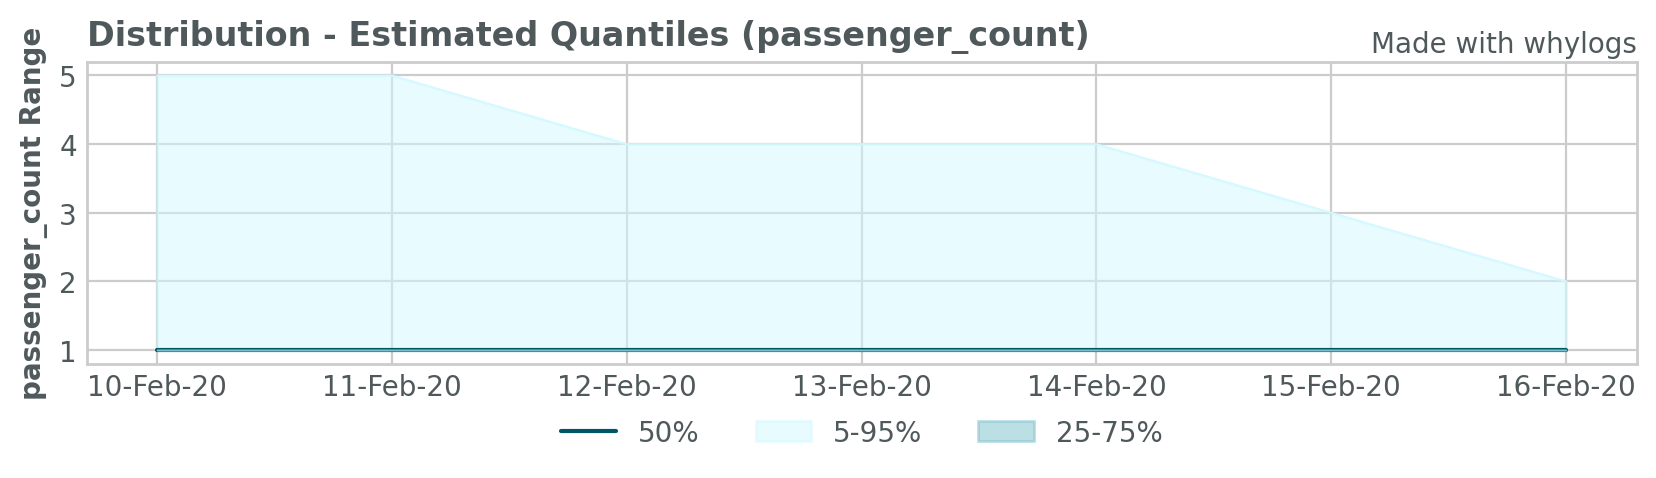

In [13]:
viz.plot_distribution("passenger_count")

The distribution of number of passengers before Feb 14 doesn't seem to be unconventional. After that, the 5-95% range falls between 1-2 passengers, which is enough to prompt a more detailed investigation.

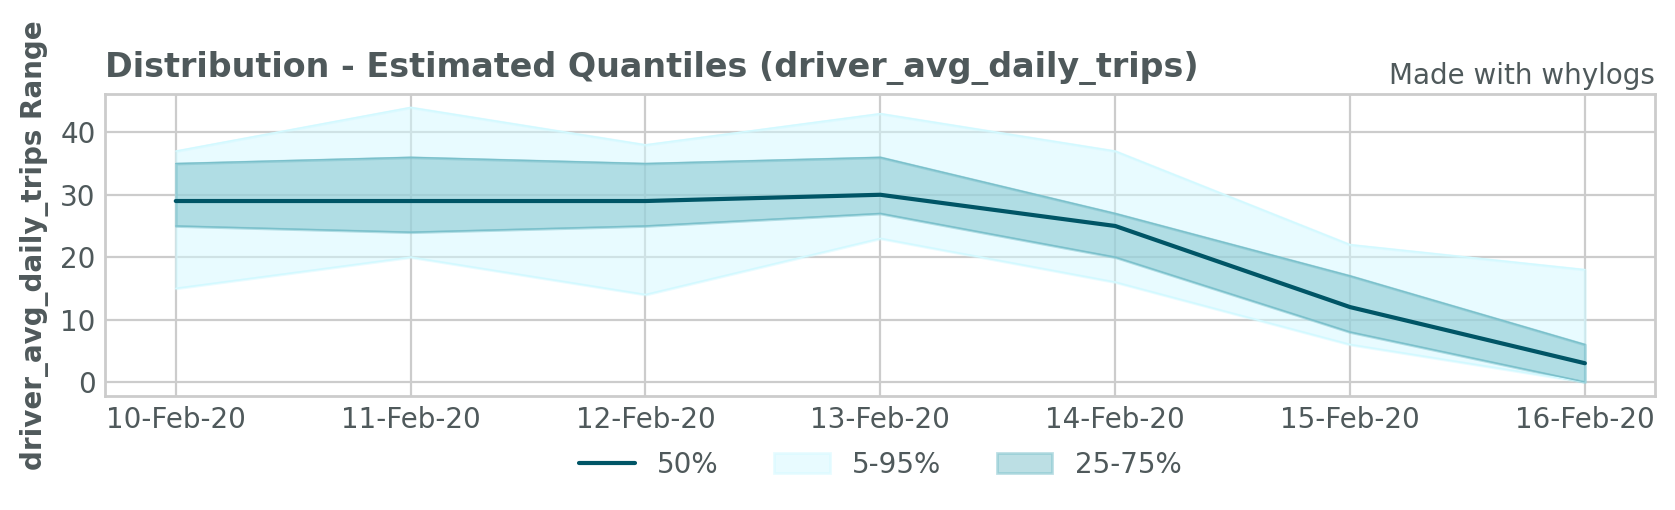

In [14]:
viz.plot_distribution("driver_avg_daily_trips")

From Feb 14 onwards, as expected, there's a visible reduction in avg daily trips, without much changes in the standard deviation.

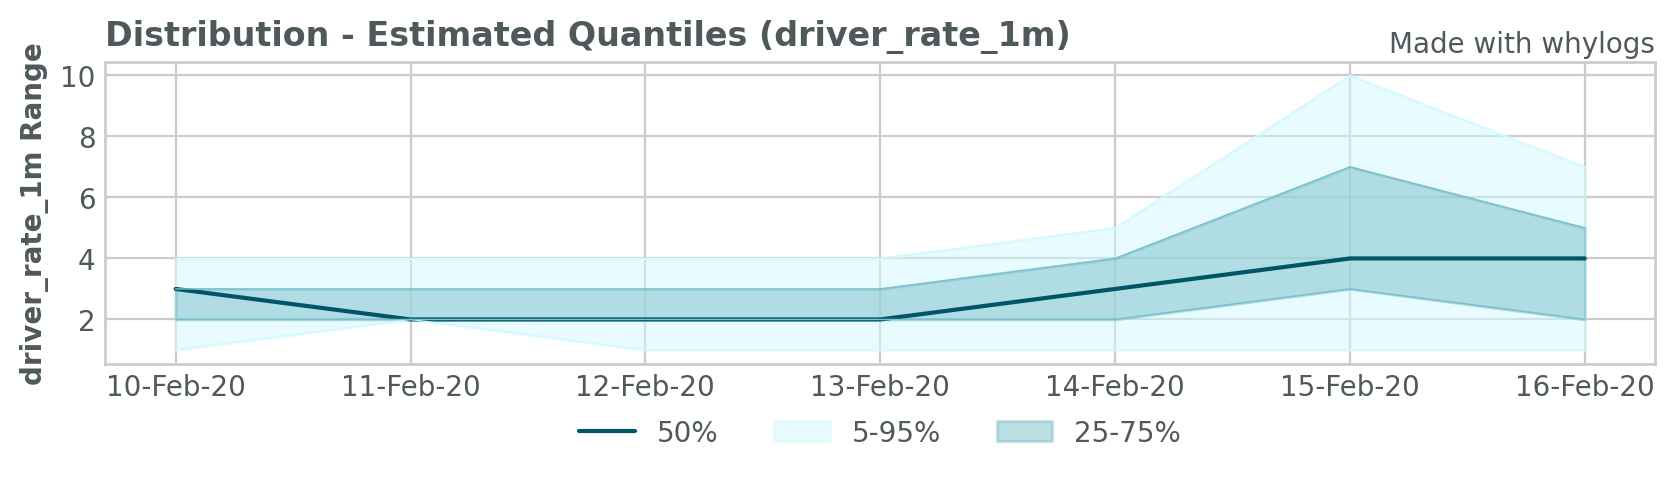

In [15]:
viz.plot_distribution("driver_rate_1m")

As with the previous plots, the changes injected in `rate_1m` is also visible by plotting the feature's distribution.

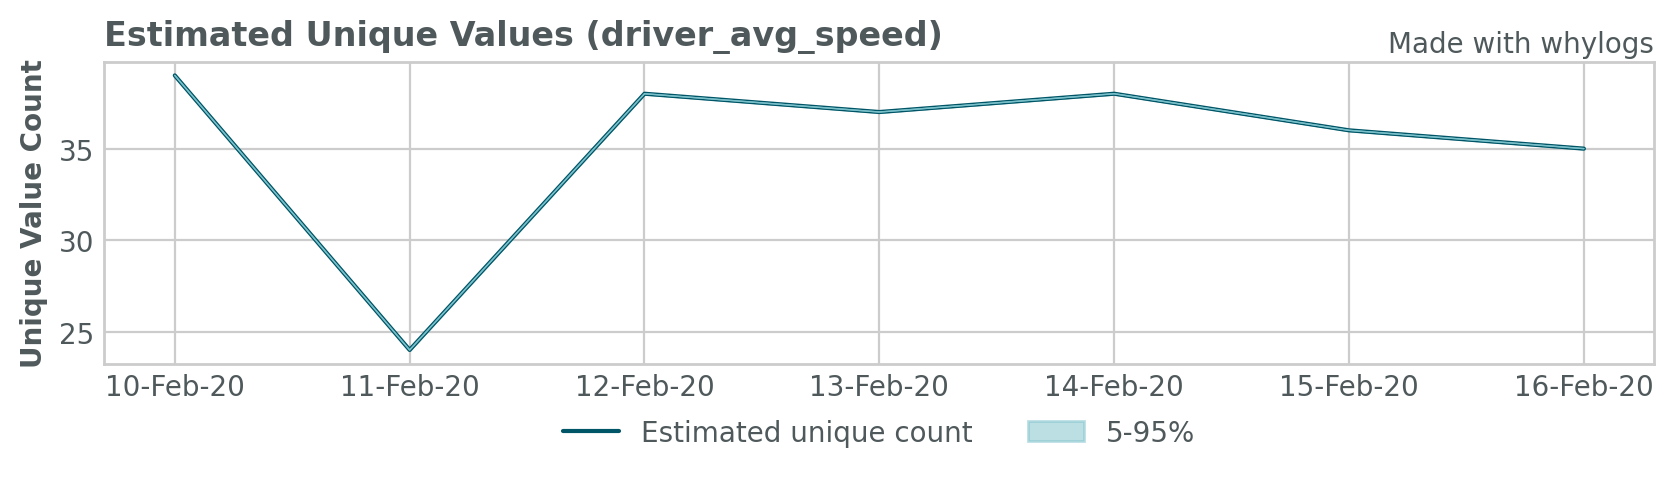

In [16]:
viz.plot_uniqueness("driver_avg_speed")

Although indirectly, the unique values of `driver_avg_speed` reflect the fact that for Feb 11 we have half the points available of driver statistics and, so, approximately half of unique values for the average speed.

# Appendix - Changing the Dataset

This section is not really a part of the demonstration. It's just to show the changes made in the dataset that originated the `driver_stats_changed.parquet` file that will be used in the beginning of the notebook.

## Driver Statistics

The NYC taxi datasets provides only information about rides, but in this example we want to show an example of using an online feature store to enrich ride information with driver statistics. So, we'll fabricate some driver statistics and link them with the rides dataset  (__nyc_taxi_rides_feb_2020.parquet__) through the `Driver_ID` key.

In [17]:
import pandas as pd


dstats = pd.DataFrame(
        {'event_timestamp': pd.date_range('2020-02-10', '2020-02-17', freq='1H', closed='left')}
     )
dstats['driver_id'] = '1001'

dstats2 = pd.DataFrame(
        {'event_timestamp': pd.date_range('2020-02-10', '2020-02-17', freq='1H', closed='left')}
     )
dstats2['driver_id'] = '1002'

dstats_tot = pd.concat([dstats, dstats2])

/tmp/ipykernel_4294/1586377622.py:5: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  {'event_timestamp': pd.date_range('2020-02-10', '2020-02-17', freq='1H', closed='left')}
/tmp/ipykernel_4294/1586377622.py:10: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  {'event_timestamp': pd.date_range('2020-02-10', '2020-02-17', freq='1H', closed='left')}


In [18]:
dstats_tot = dstats_tot.sort_values(by=["event_timestamp","driver_id"])

In [19]:
import datetime
dstats_tot['created'] = datetime.datetime.now()

In [20]:
import numpy as np

mu, sigma = 30, 6 # mean and standard deviation
s = np.random.normal(mu, sigma, len(dstats_tot))
daily_trips = np.round(s)
daily_trips = [int(x) for x in daily_trips]
dstats_tot['avg_daily_trips'] = daily_trips

In [21]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=3, sd=0.75, low=1, upp=11):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

X = get_truncated_normal()

dstats_tot['rate_1m'] = [int(x) for x in X.rvs(len(dstats_tot))]

In [22]:
import numpy as np

mu, sigma = 20, 4 # mean and standard deviation
s = np.random.normal(mu, sigma, len(dstats_tot))
avg_speed = np.round(s,2)
avg_speed
dstats_tot['avg_speed'] = avg_speed

### Adding changes - Stats Update Frequency

In [23]:
dstats_tot = dstats_tot.reset_index()
cond = (dstats_tot['event_timestamp'].dt.day==11) & (dstats_tot['event_timestamp'].dt.month==2) & ((dstats_tot['event_timestamp'].dt.hour%2)!=0)
df2 = dstats_tot.loc[cond]
dstats_tot = dstats_tot[~dstats_tot.isin(df2)].dropna()

### Adding changes - Rate_1m

We're assuming that this change in customer's behaviour would not change the mean of the distribution, but would have an increased standard deviation, making the rates be more spreaded, increasing the frequency of extreme ratings (positive or negative).

In [24]:
import numpy as np
cond = (dstats_tot['event_timestamp'].dt.day==14) & (dstats_tot['event_timestamp'].dt.month==2)
size = len(dstats_tot.loc[cond])

X = get_truncated_normal(mean=3, sd=2, low=1, upp=11)
rate_1m = [int(x) for x in X.rvs(size)]
dstats_tot.loc[cond, 'rate_1m'] = rate_1m

In [25]:
import numpy as np
cond = (dstats_tot['event_timestamp'].dt.day==15) & (dstats_tot['event_timestamp'].dt.month==2)
size = len(dstats_tot.loc[cond])

X = get_truncated_normal(mean=3, sd=3, low=1, upp=11)
rate_1m = [int(x) for x in X.rvs(size)]
dstats_tot.loc[cond, 'rate_1m'] = rate_1m

In [26]:
import numpy as np
cond = (dstats_tot['event_timestamp'].dt.day==16) & (dstats_tot['event_timestamp'].dt.month==2)
size = len(dstats_tot.loc[cond])

X = get_truncated_normal(mean=3, sd=4, low=1, upp=11)
rate_1m = [int(x) for x in X.rvs(size)]
dstats_tot.loc[cond, 'rate_1m'] = rate_1m

### Adding Changes - Avg Daily Trips

In [27]:
cond = (dstats_tot['event_timestamp'].dt.day==14) & (dstats_tot['event_timestamp'].dt.month==2)
size = len(dstats_tot.loc[cond])

mu, sigma = 24, 6 # mean and standard deviation
s = np.random.normal(mu, sigma, size)
daily_trips = np.round(s)
daily_trips = [int(x) if x>0 else 0 for x in daily_trips]
# daily_trips

dstats_tot.loc[cond, 'avg_daily_trips'] = daily_trips

In [28]:
cond = (dstats_tot['event_timestamp'].dt.day==15) & (dstats_tot['event_timestamp'].dt.month==2)
size = len(dstats_tot.loc[cond])

mu, sigma = 12, 6 # mean and standard deviation
s = np.random.normal(mu, sigma, size)
daily_trips = np.round(s)
daily_trips = [int(x) if x>0 else 0 for x in daily_trips]
# daily_trips

dstats_tot.loc[cond, 'avg_daily_trips'] = daily_trips

In [29]:
cond = (dstats_tot['event_timestamp'].dt.day==16) & (dstats_tot['event_timestamp'].dt.month==2)
size = len(dstats_tot.loc[cond])

mu, sigma = 3, 6 # mean and standard deviation
s = np.random.normal(mu, sigma, size)
daily_trips = np.round(s)
daily_trips = [int(x) if x>0 else 0 for x in daily_trips]
# daily_trips

dstats_tot.loc[cond, 'avg_daily_trips'] = daily_trips

In [30]:
dstats_tot = dstats_tot.astype({'driver_id': 'int64','avg_daily_trips':'int64','rate_1m':'int64'})
dstats_tot.to_parquet("driver_stats.parquet")

## Rides Dataset

The `nyc_taxi_rides_feb_2020.parquet` was extracted from [the TLC trip record data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). We randomly sampled the data and selected a few chosen features, in order to reduce the dataset for this demonstration.

In addition, one features was created: The day of the week, based from `tpep_pickup_datetime`.

The original features are described in this [data dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).

In [8]:
import pandas as pd

df_final = pd.read_parquet("https://whylabs-public.s3.us-west-2.amazonaws.com/whylogs_examples/nyc_taxi_rides_feb_2020.parquet")

### Reducing Passenger Count

In [9]:
cond = (df_final['tpep_pickup_datetime'].dt.day==14) & (df_final['tpep_pickup_datetime'].dt.month==2)
df_final.loc[cond, 'passenger_count'] = df_final[cond]['passenger_count'].apply(lambda x: x-1 if x>1 else 1)

cond = (df_final['tpep_pickup_datetime'].dt.day==15) & (df_final['tpep_pickup_datetime'].dt.month==2)
df_final.loc[cond, 'passenger_count'] = df_final[cond]['passenger_count'].apply(lambda x: x-2 if x-2>0 else 1)

cond = (df_final['tpep_pickup_datetime'].dt.day==16) & (df_final['tpep_pickup_datetime'].dt.month==2)
df_final.loc[cond, 'passenger_count'] = df_final[cond]['passenger_count'].apply(lambda x: x-3 if x-3>0 else 1)

In [10]:
df_final.to_parquet("nyc_taxi_rides_feb_2020_changed.parquet")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=00e43ad4-9473-4fa9-be6f-62af4ce1f0de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>